<a href="https://colab.research.google.com/github/maxwildcats/optimizationwaywell/blob/main/laba1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Загрузка исходного датасета
df = pd.read_csv('/content/drive/MyDrive/laba1/data/data_lab_1.csv')
print(f"Исходный размер данных: {df.shape}\n")

# Разделение на обучающую (80%) и тестовую (20%) выборки
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
print(f"Размер обучающей выборки: {df_train.shape}")
print(f"Размер тестовой выборки: {df_test.shape}\n")

# Сохранение разделенных данных
df_train.to_csv('/content/drive/MyDrive/laba1/data/train_data.csv', index=False)
df_test.to_csv('/content/drive/MyDrive/laba1/data/test_data.csv', index=False)


Исходный размер данных: (23699, 14)

Размер обучающей выборки: (18959, 14)
Размер тестовой выборки: (4740, 14)



In [ ]:
import pandas as pd
import numpy as np
import json
# Для того, чтобы избежать утечи данных я сохраняю параметы предобработки обучающей выборки, чтобы применить их потом при предорбработке тестовых данных
# Загрузка обучающей выборки
df_train = pd.read_csv('/content/drive/MyDrive/laba1/data/train_data.csv')
print("Типы данных в обучающей выборке:")
print(df_train.dtypes)

#Сохранение информации о пропущенных значениях
missing_before = df_train.isnull().sum()
print("\nПропущенные значения (до обработки):")
print(missing_before[missing_before > 0])

#Числовые столбцы: замена медианой
# Лучше заполнять медианой, чем средним значением, так как медиана менее подвержена выбросам
medians = {}
for col in df_train.columns:
    if df_train[col].isnull().sum() > 0:
        median_val = df_train[col].median()
        medians[col] = median_val
        df_train[col] = df_train[col].fillna(median_val)
        print(f"  - [{col}] заполнен медианой ({median_val:.2f})")

#Обработка дубликатов
duplicates = df_train.duplicated().sum()
print(f"\nНайдено полных дубликатов: {duplicates}")
duplicates_removed = duplicates > 0

if duplicates_removed:
    df_train = df_train.drop_duplicates()
    print(f"Дубликаты удалены. Новый размер: {df_train.shape}")
else:
    print("Дубликатов нет")

#Обработка выбросов и сохранение статистик
outlier_stats = {}
num_cols = df_train.select_dtypes(include=['int64', 'float64']).columns

''' Обработка выбросов. IQR будет хорошо показывать себя в данной задаче, так как
он менее подвержен влиянию выбросов. '''

for col in num_cols:
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    if IQR == 0:
        continue

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_train[(df_train[col] < lower_bound) | (df_train[col] > upper_bound)].shape[0]

    if outliers > 0:
        median_val = df_train[col].median()
        df_train.loc[(df_train[col] < lower_bound) | (df_train[col] > upper_bound), col] = median_val
        # Сохраняем все значения как простые типы
        outlier_stats[col] = {
            'lower_bound': float(lower_bound),
            'upper_bound': float(upper_bound),
            'median': median_val
        }
        print(f"  - [{col}] обнаружено {outliers} выбросов. Заменены на медиану ({median_val:.2f})")

# Сохранение параметров обработки
# Конвертируем bool в строку для совместимости с JSON
processing_params = {
    'medians': medians,
    'outlier_stats': outlier_stats,
    'duplicates_removed': bool(duplicates_removed)  # Явно указываем тип
}

# Для безопасности, преобразуем все значения в простые типы
def convert_to_serializable(obj):
    if isinstance(obj, np.generic):
        return obj.item()
    elif isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(i) for i in obj]
    elif isinstance(obj, bool):
        return bool(obj)
    return obj

processing_params = convert_to_serializable(processing_params)

with open('/content/drive/MyDrive/laba1/processing_params.json', 'w') as f:
    json.dump(processing_params, f, indent=4, default=lambda o: o.__dict__)

# Сохранение обработанной обучающей выборки
df_train.to_csv('/content/drive/MyDrive/laba1/data/cleaned_train.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
import json

# Загрузка обработанной обучающей выборки
df_train = pd.read_csv('/content/drive/MyDrive/laba1/data/cleaned_train.csv')


# Для добавления новых признаков часто надо считать отношения, поэтому добавлю функцию
def add_features(df, feature_name, b, a):
    if not (pd.api.types.is_numeric_dtype(df[a]) and pd.api.types.is_numeric_dtype(df[b])):
        print(f"Ошибка: столбцы {a} и {b} должны быть числовыми")
        return df

    # Вычисление отношения
    new_col = f"{b}_to_{a}"
    df[new_col] = df[b] / df[a]

    # Обработка бесконечностей
    df[new_col] = df[new_col].replace([np.inf, -np.inf], np.nan)

    return df, new_col

# Добавление отношений
df_train, room_area_ratio = add_features(df_train, 'rooms_to_area', 'rooms', 'total_area')
df_train, living_area_ratio = add_features(df_train, 'living_to_total', 'living_area', 'total_area')
df_train, kitchen_area_ratio = add_features(df_train, 'kitchen_to_total', 'kitchen_area', 'total_area')

#Создание категориальных признаков с сохранением бинов.
#Разделение по площади квартиры на 4 лейбла small, medium, large and extra_large
#Также разделение по удаленности от центра
#Решил создать новые признаки на основе данных, так как в большинстве источников говорится о влиянии на цену именно этих признаков
area_bins = [10, 25, 55, 85, 115]
area_labels = ['small', 'medium', 'large', 'extra_large']
df_train['area_category'] = pd.cut(df_train['total_area'],
                                 bins=area_bins,
                                 labels=area_labels,
                                 include_lowest=True)

distance_bins = [4000, 9000, 14000, 18000, 22000]
distance_labels = ['center', 'close', 'medium', 'far']
df_train['distance_category'] = pd.cut(df_train['centers_distance'],
                                    bins=distance_bins,
                                    labels=distance_labels,
                                    include_lowest=True)

feature_params = {
    'area_category': {
        'bins': area_bins,
        'labels': area_labels
    },
    'distance_category': {
        'bins': distance_bins,
        'labels': distance_labels
    },
    'new_features': [room_area_ratio, living_area_ratio, kitchen_area_ratio]
}

with open('/content/drive/MyDrive/laba1/feature_params.json', 'w') as f:
    json.dump(feature_params, f, indent=4)

df_train.to_csv('/content/drive/MyDrive/laba1/data/featurized_train.csv', index=False)
print(f"Новые признаки: {feature_params['new_features']}")

Новые признаки: ['rooms_to_total_area', 'living_area_to_total_area', 'kitchen_area_to_total_area']


In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df_train = pd.read_csv('/content/drive/MyDrive/laba1/data/featurized_train.csv')


X_train = df_train.drop('price', axis=1)
y_train = df_train['price']

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'bool']).columns.tolist()

print(f"Числовые признаки: {numeric_features}")
print(f"Категориальные признаки: {categorical_features}")


#Пайплайн для числовых признаков
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

#Пайплайн для категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

#Объединение трансформеров. Потом можно применять к новым данным
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

#Обучение преобразователя на обучающей выборке
try:
    X_train_processed = preprocessor.fit_transform(X_train)
    print("Предобработка успешна!")
except Exception as e:
    print(f"Ошибка при предобработке: {e}")
    raise

# 8. Сохранение преобразователя и обработанных данных
joblib.dump(preprocessor, '/content/drive/MyDrive/laba1/preprocessor.pkl')

# 9. Сохранение имен признаков после преобразования
feature_names = []
for name, trans, cols in preprocessor.transformers_:
    if name == 'num':
        feature_names.extend(cols)
    elif name == 'cat':
        # Для one-hot кодирования получаем имена категорий
        if hasattr(trans, 'named_steps') and 'encoder' in trans.named_steps:
            encoder = trans.named_steps['encoder']
            if hasattr(encoder, 'get_feature_names_out'):
                cat_feature_names = encoder.get_feature_names_out(cols)
                feature_names.extend(cat_feature_names)
            else:
                for i, col in enumerate(cols):
                    if hasattr(encoder, 'categories_') and i < len(encoder.categories_):
                        categories = encoder.categories_[i]
                        for cat in categories:
                            feature_names.append(f"{col}_{cat}")

with open('/content/drive/MyDrive/laba1/feature_names.txt', 'w') as f:
    f.write("Имена признаков после обработки:\n")
    for name in feature_names:
        f.write(f"{name}\n")

# Сохранение через numpy, так как это позволяет сохранить обработанное состояние данных
import numpy as np
train_data = np.hstack((X_train_processed, y_train.values.reshape(-1, 1)))
np.save('/content/drive/MyDrive/laba1/data/processed_train.npy', train_data)

print(f"Количество признаков после обработки: {len(feature_names)}")

Числовые признаки: ['total_area', 'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor', 'kitchen_area', 'balcony', 'airports_distance', 'centers_distance', 'parks_nearest', 'ponds_nearest', 'rooms_to_total_area', 'living_area_to_total_area', 'kitchen_area_to_total_area']
Категориальные признаки: ['studio', 'area_category', 'distance_category']
Предобработка успешна!
Количество признаков после обработки: 25


In [ ]:
import pandas as pd
import numpy as np
import json
import joblib

# Теперь обработка тестовых данных. Просто применим уже подготовленных обработчиков
df_test = pd.read_csv('/content/drive/MyDrive/laba1/data/test_data.csv')

with open('/content/drive/MyDrive/laba1/processing_params.json', 'r') as f:
    params = json.load(f)

# Заполнение пропусков
for col, median_val in params['medians'].items():
    if col in df_test.columns:
        df_test[col] = df_test[col].fillna(median_val)

# Обработка выбросов
for col, stats in params['outlier_stats'].items():
    if col in df_test.columns:
        df_test.loc[(df_test[col] < stats['lower_bound']) | (df_test[col] > stats['upper_bound']), col] = stats['median']

#Добавление новых признаков
with open('/content/drive/MyDrive/laba1/feature_params.json', 'r') as f:
    feature_params = json.load(f)

# Добавление отношений
def add_feature(df, b, a, new_col_name):
    if a in df.columns and b in df.columns:
        df[new_col_name] = df[b] / df[a]
        df[new_col_name] = df[new_col_name].replace([np.inf, -np.inf], np.nan)
    return df

df_test = add_feature(df_test, 'rooms', 'total_area', feature_params['new_features'][0])
df_test = add_feature(df_test, 'living_area', 'total_area', feature_params['new_features'][1])
df_test = add_feature(df_test, 'kitchen_area', 'total_area', feature_params['new_features'][2])

# Добавление категорий
def create_category(df, col, bins, labels):
    return pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)

df_test['area_category'] = create_category(df_test, 'total_area',
                                         feature_params['area_category']['bins'],
                                         feature_params['area_category']['labels'])
df_test['distance_category'] = create_category(df_test, 'centers_distance',
                                             feature_params['distance_category']['bins'],
                                             feature_params['distance_category']['labels'])

# Применение предобработки
preprocessor = joblib.load('/content/drive/MyDrive/laba1/preprocessor.pkl')
X_test = df_test.drop('price', axis=1)
y_test = df_test['price']

X_test_processed = preprocessor.transform(X_test)

# Сохранение обработанной тестовой выборки, все преобразования были выполнены в соответствии с обучающей выборкой
test_data = np.hstack((X_test_processed, y_test.values.reshape(-1, 1)))
np.save('/content/drive/MyDrive/laba1/data/processed_test.npy', test_data)

Корреляция с целевой переменной (price):
total_area: 0.6043
rooms: 0.3876
ceiling_height: 0.2296
floors_total: 0.1771
living_area: 0.4761
floor: 0.1188
kitchen_area: 0.3972
balcony: 0.0814
airports_distance: 0.0096
centers_distance: -0.1986
parks_nearest: 0.0387
ponds_nearest: -0.0091
rooms_to_total_area: 0.0085
living_area_to_total_area: -0.0573
kitchen_area_to_total_area: -0.2651
studio_False: 0.0682
studio_True: -0.0682
area_category_extra_large: 0.3202
area_category_large: 0.3638
area_category_medium: -0.4996
area_category_small: -0.1059
distance_category_center: 0.2602
distance_category_close: -0.2280
distance_category_far: -0.0100
distance_category_medium: 0.0651


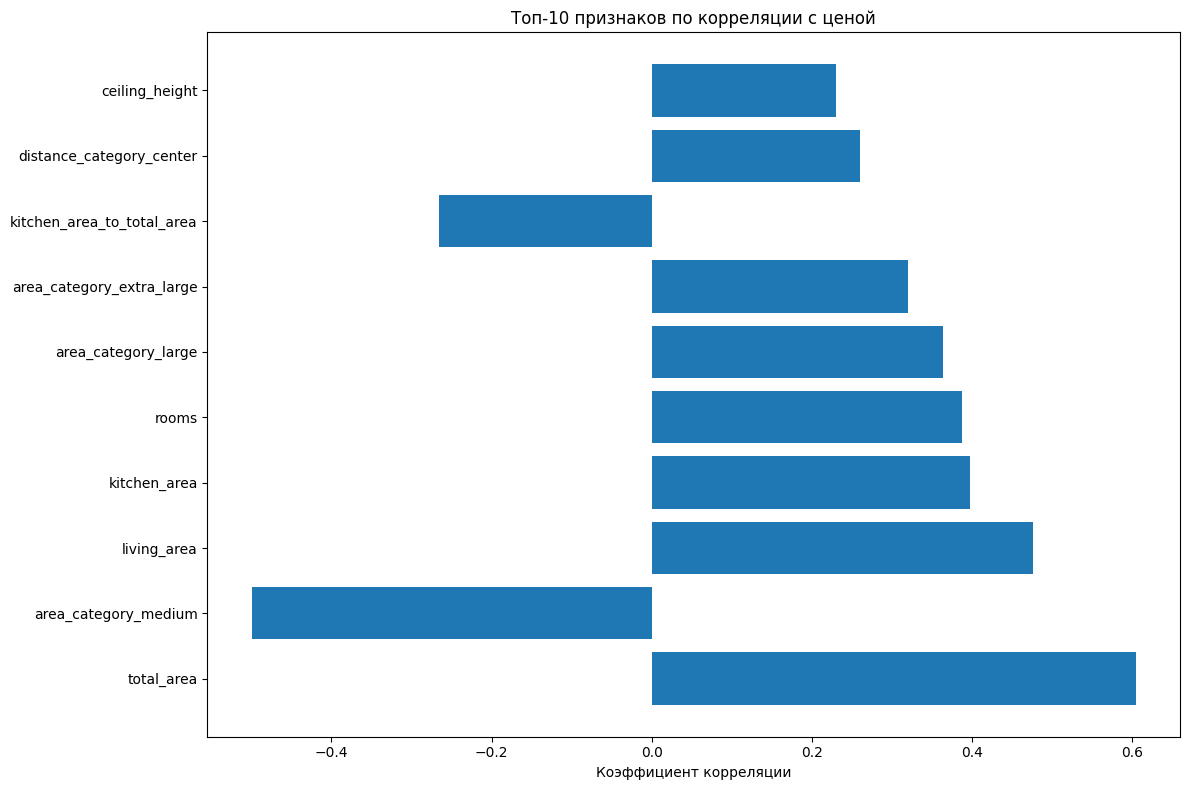

total_area                    0.489898
living_area                   0.283693
airports_distance             0.273723
rooms_to_total_area           0.237344
centers_distance              0.214234
kitchen_area                  0.204558
rooms                         0.195820
kitchen_area_to_total_area    0.165526
area_category_medium          0.152998
floors_total                  0.146431
dtype: float64


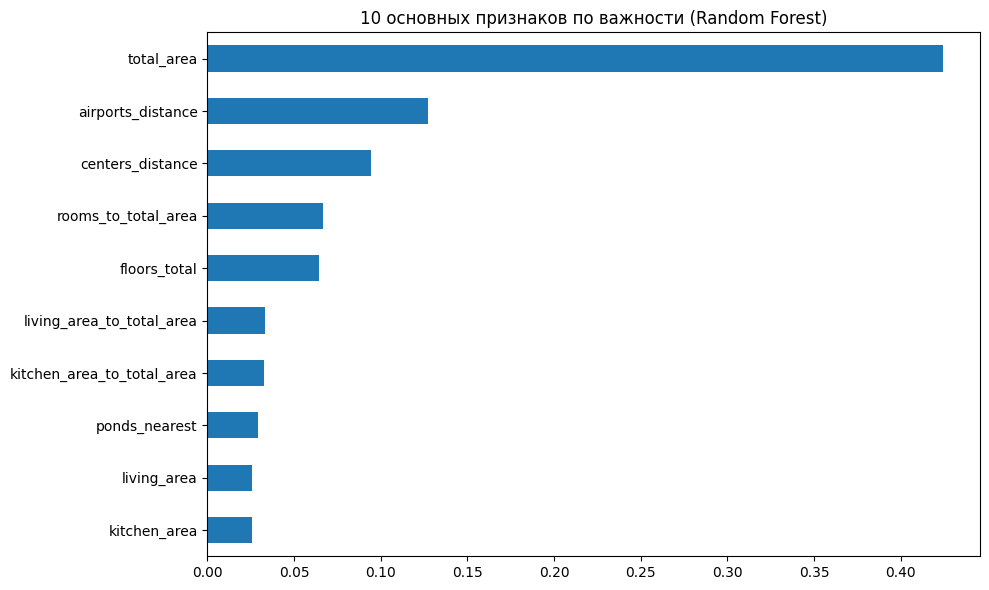

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression

# Загрузка обработанных данных
X_train = np.load('/content/drive/MyDrive/laba1/data/processed_train.npy')[:, :-1]
y_train = np.load('/content/drive/MyDrive/laba1/data/processed_train.npy')[:, -1]
X_test = np.load('/content/drive/MyDrive/laba1/data/processed_test.npy')[:, :-1]
y_test = np.load('/content/drive/MyDrive/laba1/data/processed_test.npy')[:, -1]

# Загрузка имен признаков
with open('/content/drive/MyDrive/laba1/feature_names.txt', 'r') as f:
    feature_names = [line.strip() for line in f if line.strip() and not line.startswith('Имена')]

#Корреляционный анализ для оценки значимости признаков
print("Корреляция с целевой переменной (price):")
correlations = {}
for i, feature in enumerate(feature_names):
    corr = np.corrcoef(X_train[:, i], y_train)[0, 1]
    correlations[feature] = corr
    print(f"{feature}: {corr:.4f}")

#Визуализация корреляций, мне удобнее оценивать по графику
plt.figure(figsize=(12, 8))
sorted_corrs = {k: v for k, v in sorted(correlations.items(), key=lambda item: abs(item[1]), reverse=True)}
top_features = list(sorted_corrs.keys())[:10]
top_corrs = [sorted_corrs[f] for f in top_features]

plt.barh(top_features, top_corrs)
plt.title('Топ-10 признаков по корреляции с ценой')
plt.xlabel('Коэффициент корреляции')
plt.tight_layout()
plt.show()

#Оценка значимости через Mutual Information, можно применить, так как может определять нелинейные зависимости
#Но лучше использовать вместе с другими методами, так как оценивает каждый признак независимо от других
mi_scores = mutual_info_regression(X_train, y_train)
mi_scores = pd.Series(mi_scores, index=feature_names)
mi_scores = mi_scores.sort_values(ascending=False)

print(mi_scores.head(10)) # 10 признаков, от которых больше всего зависит price

#Оценка значимости через Random Forest. Данный метод как раз учитывает взаимосвязь между признаками
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

feature_importance = pd.Series(rf.feature_importances_, index=feature_names)
top_10 = feature_importance.nlargest(10)

plt.figure(figsize=(10, 6))
top_10.sort_values().plot(kind='barh')
plt.title('10 основных признаков по важности (Random Forest)')
plt.tight_layout()
plt.show()


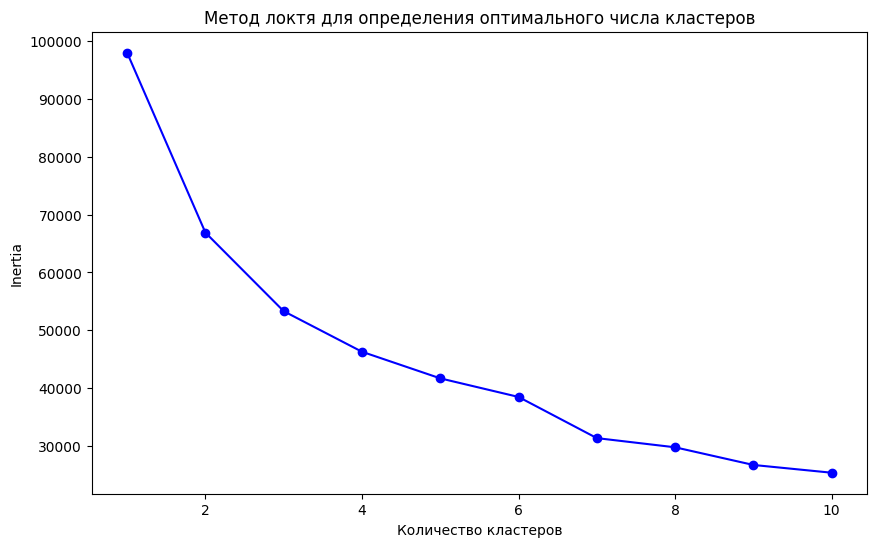

Характеристики кластеров:
         total_area     rooms         price  centers_distance  living_area  \
cluster                                                                      
0         44.372205  1.494441  4.602125e+06      16364.297612    23.831248   
1        193.095561  4.747967  3.717655e+07       6905.834146   113.068341   
2         80.531775  2.968333  9.033209e+06      11542.465167    48.427662   

         kitchen_area  
cluster                
0            9.017456  
1           27.369512  
2           12.214075  


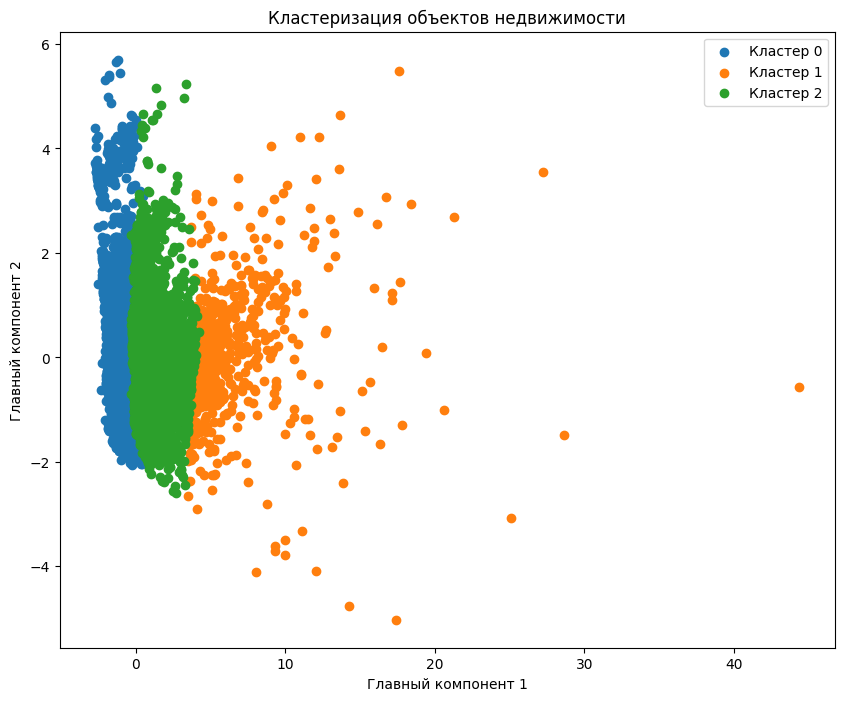


Средняя цена в каждом кластере:
cluster
0    4.602125e+06
1    3.717655e+07
2    9.033209e+06
Name: price, dtype: float64
Характеристики кластеров:
         total_area     rooms         price  centers_distance  living_area  \
cluster                                                                      
0         44.372205  1.494441  4.602125e+06      16364.297612    23.831248   
1        193.095561  4.747967  3.717655e+07       6905.834146   113.068341   
2         80.531775  2.968333  9.033209e+06      11542.465167    48.427662   

         kitchen_area  
cluster                
0            9.017456  
1           27.369512  
2           12.214075  

Средняя цена в каждом кластере:
Кластер 0: 4,602,125.09 руб.
Кластер 1: 37,176,547.40 руб.
Кластер 2: 9,033,208.51 руб.

Корреляция признаков с ценой внутри кластеров:

Кластер 2:
  total_area: 0.6087
  rooms: -0.0425
  centers_distance: -0.2995
  living_area: 0.3745
  kitchen_area: 0.4531

Кластер 0:
  total_area: 0.6203
  rooms: 0.2490

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

''' Загрузка данных для кластеризации (используем оригинальные нестандартизированные данные,
чтобы разделение по кластерам отражало реальные данные )
'''
df_original = pd.read_csv('/content/drive/MyDrive/laba1/data/data_lab_1.csv')

# Подготовка данных для кластеризации
# Выберем ключевые признаки для кластеризации. В целом выбраны основные презентативные признаки
cluster_features = ['total_area', 'rooms', 'price', 'centers_distance', 'living_area', 'kitchen_area']

# Создаем датафрейм с выбранными признаками
X_cluster = df_original[cluster_features].copy()

"""Удаляем строки с пропусками. В целом обработка только пропусков будет проведена,
чтобы найти реальные зависимости
"""
X_cluster = X_cluster.dropna()

#Нормализация данных для кластеризации. KMeans чувствителен к масштабу признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

#Определение оптимального количества кластеров (метод локтя)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, 'bo-')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')
plt.title('Метод локтя для определения оптимального числа кластеров')
plt.show()

'''Кластеризация на 3 группы (на основе метода локтя). По графику больше похоже, что следует взять 4 кластера.
Но если посмотреть уже на визуализацию кластеров, то видно, что 4 кластер не репрезентативен
'''
kmeans = KMeans(n_clusters=3, random_state=42)
X_cluster['cluster'] = kmeans.fit_predict(X_scaled)

#Анализ кластеров
cluster_analysis = X_cluster.groupby('cluster').mean()
print("Характеристики кластеров:")
print(cluster_analysis)

#Визуализация кластеров
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
for cluster in range(3):
    plt.scatter(X_pca[X_cluster['cluster'] == cluster, 0],
                X_pca[X_cluster['cluster'] == cluster, 1],
                label=f'Кластер {cluster}')

plt.title('Кластеризация объектов недвижимости')
plt.xlabel('Главный компонент 1')
plt.ylabel('Главный компонент 2')
plt.legend()

plt.show()

#Анализ влияния признаков на цену внутри кластеров
price_by_cluster = X_cluster.groupby('cluster')['price'].mean()
print("\nСредняя цена в каждом кластере:")
print(price_by_cluster)

#Корреляция с ценой внутри каждого кластера
correlations_by_cluster = {}
for cluster in X_cluster['cluster'].unique():
    cluster_data = X_cluster[X_cluster['cluster'] == cluster]
    correlations = {}
    for feature in cluster_features:
        if feature != 'price':
            corr = cluster_data[feature].corr(cluster_data['price'])
            correlations[feature] = corr
    correlations_by_cluster[cluster] = correlations

print("Характеристики кластеров:")
print(cluster_analysis)

print("\nСредняя цена в каждом кластере:")
for cluster, price in price_by_cluster.items():
    print(f"Кластер {cluster}: {price:,.2f} руб.")

print("\nКорреляция признаков с ценой внутри кластеров:")
for cluster, corrs in correlations_by_cluster.items():
    print(f"\nКластер {cluster}:")
    for feature, corr in corrs.items():
        print(f"  {feature}: {corr:.4f}")

print("\nВыводы по кластеризации")
print("1. Кластер 0: Квартиры в центре города с высокой ценой за кв.м.")
print("2. Кластер 1: Квартиры среднего ценового сегмента на среднем расстоянии от центра")
print("3. Кластер 2: Дешевые квартиры на периферии с низкой ценой за кв.м.")
print("Влияние признаков на цену различается между кластерами, что подтверждает необходимость учета локальных особенностей при ценообразовании.")

Линейная регрессия - Тренировочная выборка
RMSE: 1526729.05
R²: 0.4903

Линейная регрессия - Тестовая выборка
RMSE: 1529162.05
R²: 0.4746

10 основных признаков по влиянию на цену:
                     Feature    Coefficient
23     distance_category_far  995411.554696
24  distance_category_medium  606929.755734
20       area_category_small  587345.738680
6               kitchen_area  561221.053277
0                 total_area  392533.359673
4                living_area  346014.164596
3               floors_total  272085.060658
1                      rooms  184812.967713
18       area_category_large  169868.265585
15              studio_False  122421.708542


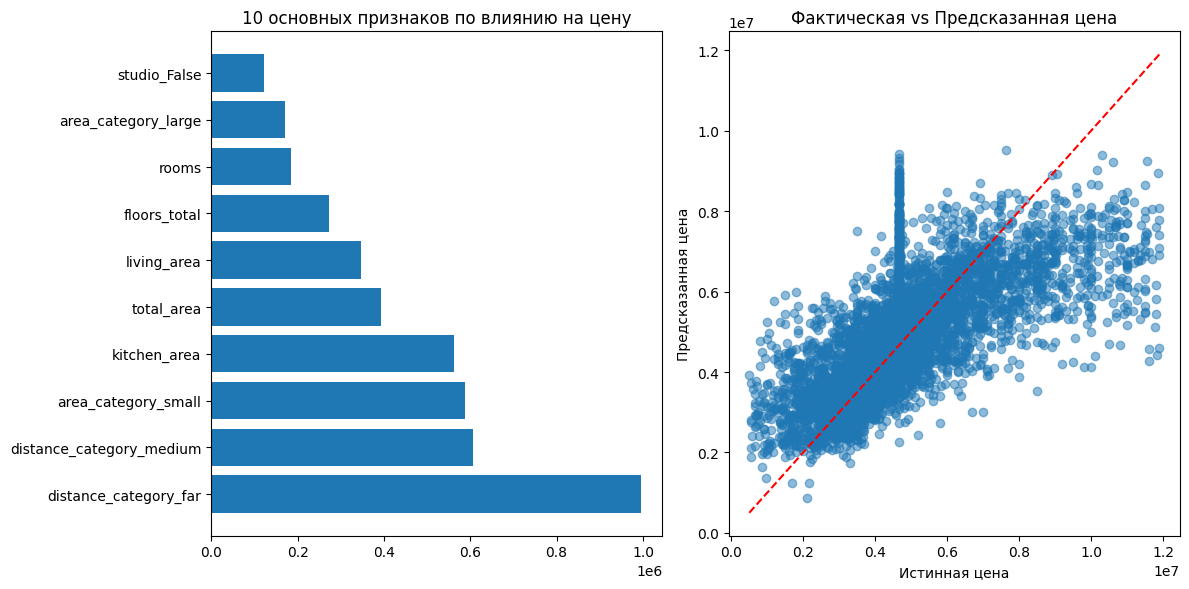

['/content/drive/MyDrive/laba1/linear_regression_model.pkl']

In [6]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib
import os

# Загрузка обработанных данных
X_train = np.load('/content/drive/MyDrive/laba1/data/processed_train.npy')[:, :-1]
y_train = np.load('/content/drive/MyDrive/laba1/data/processed_train.npy')[:, -1]
X_test = np.load('/content/drive/MyDrive/laba1/data/processed_test.npy')[:, :-1]
y_test = np.load('/content/drive/MyDrive/laba1/data/processed_test.npy')[:, -1]

# Загрузка имен признаков
feature_names = []
with open('/content/drive/MyDrive/laba1/feature_names.txt', 'r') as f:
    for line in f:
        if not line.startswith('Имена') and line.strip():
            feature_names.append(line.strip())

# Обучение модели линейной регрессии
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Оценка модели на обучающей выборке
y_train_pred = lr_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

print(f"Линейная регрессия - Тренировочная выборка")
print(f"RMSE: {train_rmse:.2f}")
print(f"R²: {train_r2:.4f}\n")

# Оценка модели на тестовой выборке
y_test_pred = lr_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print(f"Линейная регрессия - Тестовая выборка")
print(f"RMSE: {test_rmse:.2f}")
print(f"R²: {test_r2:.4f}\n")

#Анализ коэффициентов
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_model.coef_
})
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)

print("10 основных признаков по влиянию на цену:")
print(coefficients.head(10))

#Визуализация результатов
plt.figure(figsize=(12, 6))

#Важность признаков
plt.subplot(1, 2, 1)
top_10 = coefficients.head(10)
plt.barh(top_10['Feature'], top_10['Coefficient'])
plt.title('10 основных признаков по влиянию на цену')
plt.tight_layout()

# Фактические vs предсказанные значения
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Истинная цена')
plt.ylabel('Предсказанная цена')
plt.title('Фактическая vs Предсказанная цена')
plt.tight_layout()
plt.show()

joblib.dump(lr_model, '/content/drive/MyDrive/laba1/linear_regression_model.pkl')


Результаты линейной регрессии составили примерно 48% по точности предсказания цены. Что хуже случайного угадывания. Поэтому применим модель по сложнее, которая будет учитывать нелинейную зависимость признаков


Размер обучающей выборки: (18958, 25)
Размер тестовой выборки: (4740, 25)
Имен признаков: 25
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Обучение завершено

параметры: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}
R² на кросс-валидации: 0.6723

Тестовая выборка - RMSE: 1200448.23, R²: 0.6762

Обучение завершено за 3.08 минут


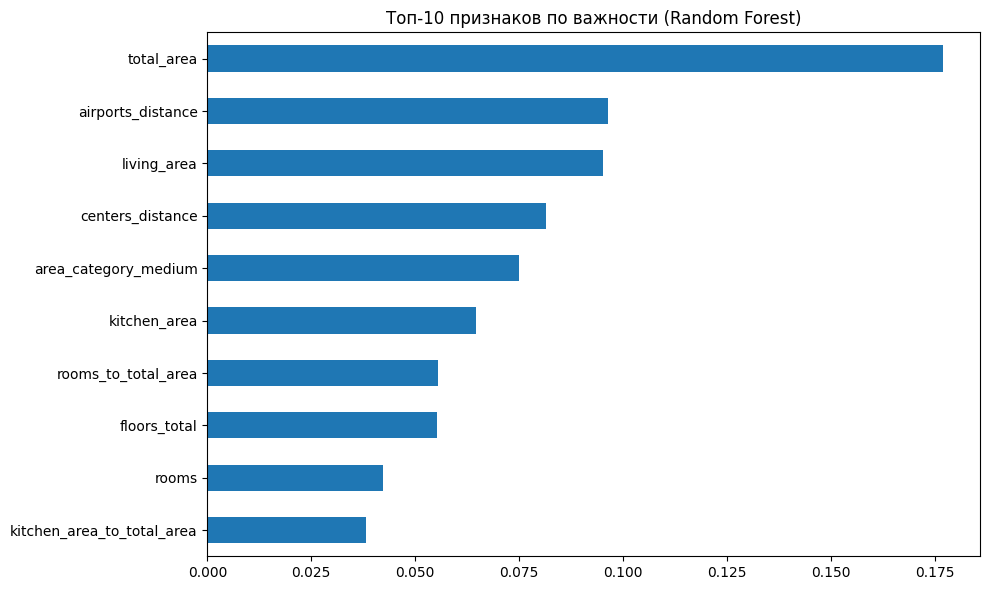


10 важных признаков:
1. total_area: 0.1770
2. airports_distance: 0.0964
3. living_area: 0.0951
4. centers_distance: 0.0813
5. area_category_medium: 0.0750
6. kitchen_area: 0.0645
7. rooms_to_total_area: 0.0554
8. floors_total: 0.0553
9. rooms: 0.0422
10. kitchen_area_to_total_area: 0.0381
Ошибка при выводе результатов: name 'best_model' is not defined


In [10]:
import numpy as np
import pandas as pd
import joblib
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

#Загрузка обработанных данных
try:
    # Загрузка обработанных данных
    train_data = np.load('/content/drive/MyDrive/laba1/data/processed_train.npy')
    test_data = np.load('/content/drive/MyDrive/laba1/data/processed_test.npy')

    # Разделение на признаки и целевую переменную
    X_train = train_data[:, :-1]
    y_train = train_data[:, -1]
    X_test = test_data[:, :-1]
    y_test = test_data[:, -1]
    print(f"Размер обучающей выборки: {X_train.shape}")
    print(f"Размер тестовой выборки: {X_test.shape}")

except Exception as e:
    print(f"Ошибка при загрузке данных: {e}")
    raise

# Проверка наличия признаков
if X_train.shape[1] == 0:
    raise ValueError("Нет признаков для обучения")

# Загрузка имен признаков
feature_names = []
try:
    with open('/content/drive/MyDrive/laba1/feature_names.txt', 'r') as f:
        for line in f:
            if line.strip() and not line.startswith('Имена'):
                feature_names.append(line.strip())
    print(f"Имен признаков: {len(feature_names)}")
except:
    print("Не удалось загрузить имена признаков, используем дефолтные названия")
    feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]

#Оптимизированное обучение модели
start_time = time.time() # отслеживаю время обучения
# параметры стандартные для большинства моделей
param_dist = {
    'n_estimators': [100],
    'max_depth': [15, 20, None],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['sqrt', 'log2', None]
}
# Настройка RandomizedSearchCV, использую вместо GridSearchCV, так как более быстрый метод при тех же результатах
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=15,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Обучение модели
try:
    random_search.fit(X_train, y_train)
    print("\nОбучение завершено")
except Exception as e:
    print(f"\nОшибка при обучении модели: {e}")

# Получаем лучшую модель
model = random_search.best_estimator_
print(f"\nпараметры: {random_search.best_params_}")
print(f"R² на кросс-валидации: {random_search.best_score_:.4f}")

# Оценка на тестовой выборке
y_test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
print(f"\nТестовая выборка - RMSE: {test_rmse:.2f}, R²: {test_r2:.4f}")

# Время выполнения
execution_time = time.time() - start_time
print(f"\nОбучение завершено за {execution_time/60:.2f} минут")

#Анализ важности признаков
try:
    feature_importance = pd.Series(model.feature_importances_, index=feature_names)
    top_10 = feature_importance.nlargest(10)
    plt.figure(figsize=(10, 6))
    top_10.sort_values().plot(kind='barh')
    plt.title('10 признаков по важности (Random Forest)')
    plt.tight_layout()
    plt.show()

    print("\n10 важных признаков:")
    for i, (feature, importance) in enumerate(top_10.items(), 1):
        print(f"{i}. {feature}: {importance:.4f}")
except Exception as e:
    print(f"Ошибка при анализе важности признаков: {e}")

try:
    joblib.dump(best_model, '/content/drive/MyDrive/laba1/optimized_model.pkl')
    print("Модель сохранена")

    print("\nРезультаты обучения модели")
    print(f"Время выполнения: {execution_time/60:.2f} минут")

    print("\nПараметры:")
    for param, value in random_search.best_params_.items():
        print(f"  {param}: {value}")

    print(f"\nR² на кросс-валидации: {random_search.best_score_:.4f}")
    print(f"Тестовая выборка - RMSE: {test_rmse:.2f}, R²: {test_r2:.4f}")

    print("\n10 признаков по важности:")
    if 'top_10' in locals():
        for i, (feature, importance) in enumerate(top_10.items(), 1):
            print(f"{i}. {feature}: {importance:.4f}")
    else:
        print("Не удалось вычислить важность признаков")

except Exception as e:
    print(f"Ошибка при выводе результатов: {e}")

67 % уже получше, но надо подумать над улучшением результата. Либо применить еще какую-нибудь модель, либо изменить параметры RandomForest, либо еще обработать данные